In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import re
#import plotly as py
#import plotly.graph_objs as go

from pandas.api.types import is_string_dtype, is_numeric_dtype
plt.style.use('ggplot')
pd.set_option('display.max_rows', 200, 'display.max_columns', 200)
pd.options.display.float_format = '{:,.2f}'.format


In [2]:
raw_df = pd.read_csv("data/loan.csv")

/Users/innoppl/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (47) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


1. Remove current status loans
2. Drop unnecessary columns not related to the loans
3. Fix Rows and columns. ensure standardized naming.
4. Identify a single unique identifier
5. Identify missing values. 
5a. Ignore columns with majoirty missing value
5b. use missing value replacement techniques
6. Fix invalid values
7. Outlier Treatment
8. Standardize values


In [3]:
raw_df.shape

(39717, 111)

# Custom function for reusability 

In [4]:
# Below are reuseable function for drawing polts 

In [5]:
def plot_bar_chart(plotting_frame,x_column,y_column) :
            
        x_axis_title = x_column.title()
        y_axis_title = y_column.title()
        
        graph_title = "Bar Chart [" + x_axis_title.title() + " Vs " + y_axis_title.title() + "]"
        
        layout = go.Layout(
             title = graph_title,
             yaxis=dict(
                title=y_axis_title
             ),
             xaxis=dict(
                 title=x_axis_title
             )
        )

        data_to_be_plotted = [
            go.Bar(
                x=plotting_frame[x_column], 
                y=plotting_frame[y_column]
            )
        ]


        figure = go.Figure(data=data_to_be_plotted,layout=layout)
        py.offline.iplot(figure)
        

In [6]:
def plot_box_chart(dataframe) :
    data = []
    for index, column_name in enumerate(dataframe) :
        data.append(
        go.Box(
            y=dataframe.iloc[:, index],
            name=column_name
         ))   
        
    layout = go.Layout(
    yaxis=dict(
        title="Frequency",
        zeroline=False
    ),
       boxmode='group'
    )
    
    fig = go.Figure(data=data, layout=layout)    
    py.offline.iplot(fig)

In [7]:
def plot_pie_chart(plotting_frame,x_column,y_column) : 
        
        labels = plotting_frame[x_column].tolist()
        values = plotting_frame[y_column].tolist()

        trace = go.Pie(labels=labels, values=values)

        py.offline.iplot([trace])

In [8]:
# Custom function for meta data like count, datatype, null count and percentage 

In [9]:
def getMetaOfDataFrame(df) :
    metadata_info = pd.DataFrame({
        'Total_Element Counts': df.count(), # total elements in columns            
        'Datatype' : df.dtypes, # data types of columns
        'Null_Count': df.isnull().sum(), # total null values in columns
        'Null_Percentage': df.isnull().sum()/len(df) * 100 # percentage of null values
                       })
    return metadata_info

In [10]:
#loan_metadata = getMetaOfDataFrame(raw_df)
#loan_metadata_group = loan_metadata.groupby("Null_Percentage").count().reset_index()
#loan_metadata_group.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
#plot_pie_chart(loan_metadata_group,"Null_Percentage","Null_Count")

## 1. Check for fixing rows and columns

In [11]:
raw_df.head(5) ## Check for header and footer rows

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_il_6m,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,1077501,1296599,5000,5000,"4,975.00",36 months,10.65%,162.87,B,B2,NaN,10+ years,RENT,"24,000.00",Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I need to upgra...,credit_card,Computer,860xx,AZ,27.65,0,Jan-85,1,NaN,NaN,3,0,13648,83.70%,9,f,0.00,0.00,"5,863.16","5,833.84","5,000.00",863.16,0.00,0.00,0.00,Jan-15,171.62,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
1,1077430,1314167,2500,2500,"2,500.00",60 months,15.27%,59.83,C,C4,Ryder,< 1 year,RENT,"30,000.00",Source Verified,Dec-11,Charged Off,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/22/11 > I plan to use t...,car,bike,309xx,GA,1.00,0,Apr-99,5,NaN,NaN,3,0,1687,9.40%,4,f,0.00,0.00,"1,008.71","1,008.71",456.46,435.17,0.00,117.08,1.11,Apr-13,119.66,NaN,Sep-13,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
2,1077175,1313524,2400,2400,"2,400.00",36 months,15.96%,84.33,C,C5,NaN,10+ years,RENT,"12,252.00",Not Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,small_business,real estate business,606xx,IL,8.72,0,Nov-01,2,NaN,NaN,2,0,2956,98.50%,10,f,0.00,0.00,"3,005.67","3,005.67","2,400.00",605.67,0.00,0.00,0.00,Jun-14,649.91,NaN,May-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,NaN,NaN,NaN,NaN
3,1076863,1277178,10000,10000,"10,000.00",36 months,13.49%,339.31,C,C1,AIR RESOURCES BOARD,10+ years,RENT,"49,200.00",Source Verified,Dec-11,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,Borrower added on 12/21/11 > to pay for prop...,other,personel,917xx,CA,20.00,0,Feb-96,1,35.00,NaN,10,0,5598,21%,37,f,0.00,0.00,"12,231.89","12,231.89","10,000.00","2,214.92",16.97,0.00,0.00,Jan-15,357.48,NaN,Apr-16,0.00,NaN,1,INDIVIDUAL,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [12]:
## check for empty/weird column names
for col in raw_df.columns:
    print(col)

id
member_id
loan_amnt
funded_amnt
funded_amnt_inv
term
int_rate
installment
grade
sub_grade
emp_title
emp_length
home_ownership
annual_inc
verification_status
issue_d
loan_status
pymnt_plan
url
desc
purpose
title
zip_code
addr_state
dti
delinq_2yrs
earliest_cr_line
inq_last_6mths
mths_since_last_delinq
mths_since_last_record
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
out_prncp
out_prncp_inv
total_pymnt
total_pymnt_inv
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_d
last_pymnt_amnt
next_pymnt_d
last_credit_pull_d
collections_12_mths_ex_med
mths_since_last_major_derog
policy_code
application_type
annual_inc_joint
dti_joint
verification_status_joint
acc_now_delinq
tot_coll_amt
tot_cur_bal
open_acc_6m
open_il_6m
open_il_12m
open_il_24m
mths_since_rcnt_il
total_bal_il
il_util
open_rv_12m
open_rv_24m
max_bal_bc
all_util
total_rev_hi_lim
inq_fi
total_cu_tl
inq_last_12m
acc_open_past_24mths
avg_cur_bal
bc_open_to_buy
bc

In [13]:
## Keep one id column out of member id, id
## Drop columns with less variation in its values
## Tackle null values

In [14]:
null_percentage = (raw_df.isnull().sum() / raw_df.shape[0] * 100.00).reset_index()
null_percentage.columns = ['column_name','null_percent']
null_percentage = null_percentage.sort_values('null_percent', ascending=False)
null_percentage

,column_name,null_percent
55,verification_status_joint,100.00
53,annual_inc_joint,100.00
81,mo_sin_old_rev_tl_op,100.00
80,mo_sin_old_il_acct,100.00
77,bc_util,100.00
76,bc_open_to_buy,100.00
75,avg_cur_bal,100.00
74,acc_open_past_24mths,100.00
73,inq_last_12m,100.00
72,total_cu_tl,100.00


In [15]:
columns_to_remove = null_percentage[null_percentage.null_percent>=100].column_name.to_list()

In [16]:
## Member id vs loan id

In [17]:
raw_df.id.nunique(), raw_df.member_id.nunique() # there is unique per row, we can drop either of them

(39717, 39717)

In [18]:
columns_to_remove.append('member_id')

In [19]:
columns_to_remove

['verification_status_joint',
 'annual_inc_joint',
 'mo_sin_old_rev_tl_op',
 'mo_sin_old_il_acct',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'inq_last_12m',
 'total_cu_tl',
 'inq_fi',
 'total_rev_hi_lim',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'tot_cur_bal',
 'tot_coll_amt',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'total_bal_ex_mort',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_sats',
 'num_rev_accts',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_il_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'num_accts_ever_120_pd',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_inq',
 'mths_since_recent_bc_dlq',
 'dti_joint',
 '

In [20]:
columns_to_keep = [x for x in raw_df.columns if x not in columns_to_remove]

In [21]:
len(raw_df.columns), len(columns_to_keep),len(columns_to_remove)

(111, 56, 55)

In [22]:
non_null_df = raw_df[columns_to_keep]

In [23]:
non_null_df.shape

(39717, 56)

In [24]:
non_null_df.columns

Index(['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate',
       'installment', 'grade', 'sub_grade', 'emp_title', 'emp_length',
       'home_ownership', 'annual_inc', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'initial_list_status', 'out_prncp', 'out_prncp_inv', 'total_pymnt',
       'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'next_pymnt_d', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens'],
      dtype

In [25]:
# Identify textual columns to split in the above list and split - 

In [26]:
# Identify % of missing values in each column and suggest appropriate solution
percent_missing = non_null_df.isnull().sum() * 100 / len(non_null_df)
print(percent_missing)

id                            0.00
loan_amnt                     0.00
funded_amnt                   0.00
funded_amnt_inv               0.00
term                          0.00
int_rate                      0.00
installment                   0.00
grade                         0.00
sub_grade                     0.00
emp_title                     6.19
emp_length                    2.71
home_ownership                0.00
annual_inc                    0.00
verification_status           0.00
issue_d                       0.00
loan_status                   0.00
pymnt_plan                    0.00
url                           0.00
desc                         32.58
purpose                       0.00
title                         0.03
zip_code                      0.00
addr_state                    0.00
dti                           0.00
delinq_2yrs                   0.00
earliest_cr_line              0.00
inq_last_6mths                0.00
mths_since_last_delinq       64.66
mths_since_last_reco

In [27]:
## Check column variations
columns_to_remove2 = non_null_df.columns[non_null_df.nunique(dropna=True) <= 1].to_list()
# add textual columns of no use
columns_to_remove2.append('desc')
columns_to_remove2.append('url')


In [28]:
non_null_df2= non_null_df[[x for x in non_null_df.columns if x not in columns_to_remove2]]
non_null_df2.dtypes.sort_values()

id                           int64
open_acc                     int64
pub_rec                      int64
revol_bal                    int64
total_acc                    int64
inq_last_6mths               int64
delinq_2yrs                  int64
funded_amnt                  int64
loan_amnt                    int64
total_rec_int              float64
total_rec_prncp            float64
total_pymnt_inv            float64
recoveries                 float64
out_prncp_inv              float64
out_prncp                  float64
collection_recovery_fee    float64
last_pymnt_amnt            float64
mths_since_last_record     float64
mths_since_last_delinq     float64
total_rec_late_fee         float64
total_pymnt                float64
pub_rec_bankruptcies       float64
funded_amnt_inv            float64
installment                float64
annual_inc                 float64
dti                        float64
last_credit_pull_d          object
next_pymnt_d                object
last_pymnt_d        

In [29]:
# Meta function value check 
getinfo = getMetaOfDataFrame(non_null_df2) 



In [30]:
# Here for the columns the null percentage is more than 50% so remove it. 
getinfo
non_null_df2 = non_null_df2.drop(['next_pymnt_d','mths_since_last_delinq','mths_since_last_record'], axis = 1)
getinfo = getMetaOfDataFrame(non_null_df2) 
getinfo

,Total_Element Counts,Datatype,Null_Count,Null_Percentage
id,39717,int64,0,0.00
loan_amnt,39717,int64,0,0.00
funded_amnt,39717,int64,0,0.00
funded_amnt_inv,39717,float64,0,0.00
term,39717,object,0,0.00
int_rate,39717,object,0,0.00
installment,39717,float64,0,0.00
grade,39717,object,0,0.00
sub_grade,39717,object,0,0.00
emp_title,37258,object,2459,6.19


In [31]:
# Converting string percentage of 'revol_util' to float value without percentage symbol
non_null_df2['revol_util'] = non_null_df2['revol_util'].str.rstrip('%').astype('float') / 100.0

# Converting string percentage of 'int_rate' to float value without percentage symbol
non_null_df2['int_rate'] = non_null_df2['int_rate'].str.rstrip('%').astype('float') / 100.0

#converting 'term' string to 'term' int by removing ' months'
non_null_df2['term'] = non_null_df2['term'].str.replace(' months', '', regex=True).astype(int)

# converting 'emp_length' string into float by removing 'year','years' and consider '10+' to '10'. Also '< 1' to '0.5'
non_null_df2['emp_length'] = non_null_df2['emp_length'].str.replace('years','').str.replace('year','').str.replace('10\+ ','10',regex=True).str.replace('< 1 ', '0.5')
non_null_df2['emp_length'] = non_null_df2['emp_length'].astype(float)

non_null_df2.dtypes.sort_values()

id                           int64
open_acc                     int64
pub_rec                      int64
revol_bal                    int64
total_acc                    int64
inq_last_6mths               int64
delinq_2yrs                  int64
term                         int64
funded_amnt                  int64
loan_amnt                    int64
total_rec_late_fee         float64
total_rec_int              float64
total_rec_prncp            float64
collection_recovery_fee    float64
total_pymnt                float64
out_prncp_inv              float64
out_prncp                  float64
revol_util                 float64
last_pymnt_amnt            float64
recoveries                 float64
total_pymnt_inv            float64
dti                        float64
pub_rec_bankruptcies       float64
funded_amnt_inv            float64
int_rate                   float64
installment                float64
annual_inc                 float64
emp_length                 float64
last_pymnt_d        

In [32]:
# Just check all index are float 
non_null_df2.emp_length.value_counts().index

Float64Index([10.0, 0.5, 2.0, 3.0, 4.0, 5.0, 1.0, 6.0, 7.0, 8.0, 9.0], dtype='float64')

# Univariant Plotting - categorical 

Text(0.5, 1.0, 'Frequency of purpose')

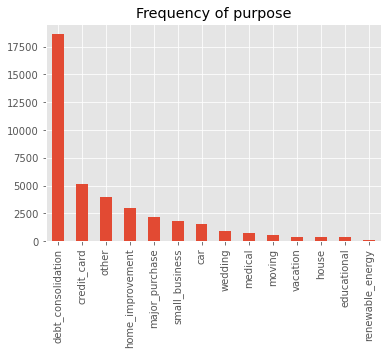

In [33]:
# Univariate - Categorical - UnOrdered - Bar plot 
non_null_df2['purpose'].value_counts().sort_values(ascending=False).plot.bar()
plt.title('Frequency of purpose')

<AxesSubplot:>

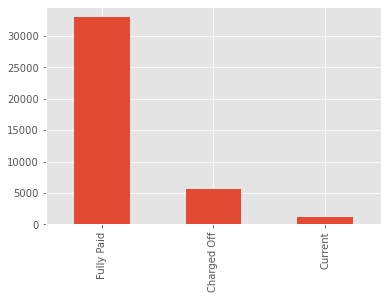

In [34]:

# We need only charged and full paid records. So ploting bar chart to see range of loan_status as current and remove it 
non_null_df2['loan_status'].value_counts().sort_values(ascending=False).plot.bar()

In [35]:
# Saving to all_record_after_cleaning data frame to get total count of charged, Fully paid and current records. 
all_record_After_Cleaning = non_null_df2

In [36]:
all_record_After_Cleaning.shape 

(39717, 42)

In [37]:
# Here the loan status with current are removed 
non_null_df2 = non_null_df2[non_null_df2.loan_status != "Current"]

In [38]:
non_null_df2.shape

(38577, 42)

<AxesSubplot:>

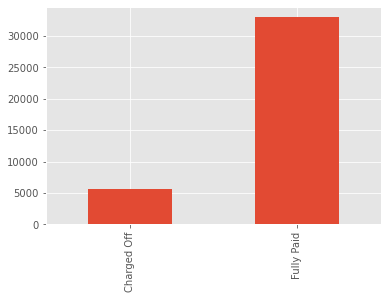

In [39]:
# Just confirming with Bar chart 
non_null_df2['loan_status'].value_counts().sort_index().plot.bar()

In [40]:
# One of sample for drawing pie chart using custom function 

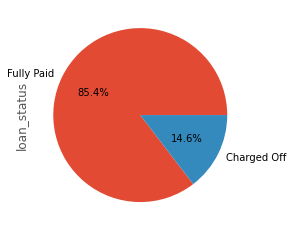

In [41]:
non_null_df2["loan_status"].value_counts(1).plot(kind="pie",autopct="%.1f%%")
plt.show()

<AxesSubplot:ylabel='Frequency'>

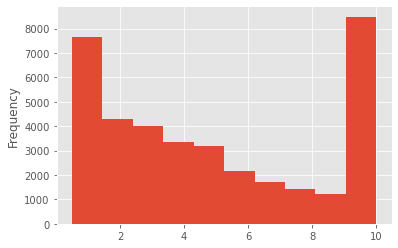

In [42]:
# Univariate - Categorical - Ordered - histogram plot 
non_null_df2['emp_length'].plot.hist()

In [43]:
 # There should be better bucketing system for employees more 10+

In [44]:
# You can see 45 columns now 
non_null_df2.shape

(38577, 42)

In [45]:

# Derive a columns "year" and "month" from single column "issue_d"
non_null_df2.issue_d = pd.to_datetime(non_null_df2.issue_d, format='%b-%y')
non_null_df2['year']=non_null_df2['issue_d'].dt.year
non_null_df2['month']=non_null_df2['issue_d'].dt.month

# Two new dervived column as be created
non_null_df2.shape

/Users/innoppl/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2071/2850595559.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_null_df2['year']=non_null_df2['issue_d'].dt.year
/var/folders/qg/f8f8j4192yd6xfhtrhlvy3gw0000gn/T/ipykernel_2071/2850595559.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

(38577, 44)

In [46]:
# Univaraite - Numeric - Box Plot for single varibale loan amount

In [47]:
non_null_df2['loan_amnt'].describe()
# Below you can see, 
# 15000 loan amount in 75 percentile range 
# 9600  loan amount in 50 percentile range
# 5300  loan in 25 percentile range

# Max value is 35000.00 loan amount 

count   38,577.00
mean    11,047.03
std      7,348.44
min        500.00
25%      5,300.00
50%      9,600.00
75%     15,000.00
max     35,000.00
Name: loan_amnt, dtype: float64

<AxesSubplot:>

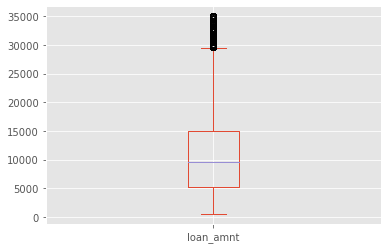

In [48]:
non_null_df2['loan_amnt'].plot.box()


In [49]:
non_null_df2["annual_inc"].describe()

# Below you can see, 
# 82,000.00 Annual Income in 75 percentile range 
# 58,868.00 Annual Income in 50 percentile range
# 40,000.00 Annual Income in 25 percentile range

# Max value is 6,000,000.00 loan amount which is definitely a outlier


count      38,577.00
mean       68,777.97
std        64,218.68
min         4,000.00
25%        40,000.00
50%        58,868.00
75%        82,000.00
max     6,000,000.00
Name: annual_inc, dtype: float64

In [50]:
np.quantile(non_null_df2["annual_inc"],[0,0.01,0.05,0.1,0.25,0.50,0.75,0.9,0.95,0.99,1])

array([4.00000e+03, 1.44000e+04, 2.40000e+04, 3.00000e+04, 4.00000e+04,
       5.88680e+04, 8.20000e+04, 1.15000e+05, 1.40004e+05, 2.34144e+05,
       6.00000e+06])

In [51]:
# So definitely this neededs outliers treamen

non_null_df2["annual_inc"].quantile(0.01)
non_null_df2["annual_inc"].quantile(0.99)

# Remove Outliers > 0.10 quantile and < .99 from Annual Income
non_null_df2 = non_null_df2[(non_null_df2["annual_inc"] > non_null_df2["annual_inc"].quantile(0.10)) & (non_null_df2["annual_inc"] < non_null_df2["annual_inc"].quantile(0.99))]

# After Removal of Outliers 
print(non_null_df2["annual_inc"].describe())

count    33,640.00
mean     70,953.77
std      33,638.17
min      30,004.00
25%      46,874.53
50%      62,000.00
75%      85,000.00
max     234,000.00
Name: annual_inc, dtype: float64


<AxesSubplot:>

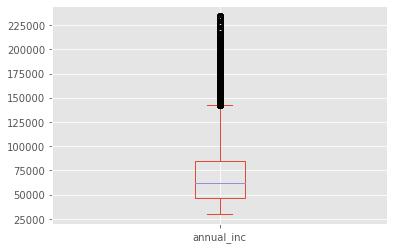

In [52]:
non_null_df2['annual_inc'].plot.box()

<AxesSubplot:>

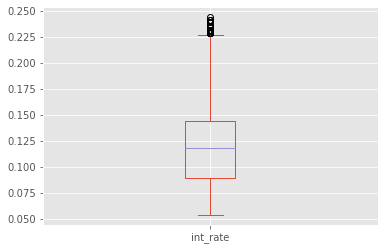

In [53]:
non_null_df2['int_rate'].plot.box()

# The interest rate is distributed between 9.07 and 14.54

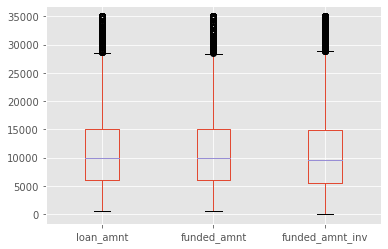

In [54]:
# Mulit varibale box plotting 
boxplot = non_null_df2.boxplot(column=['loan_amnt', 'funded_amnt', 'funded_amnt_inv'])

# Segmented Analysis

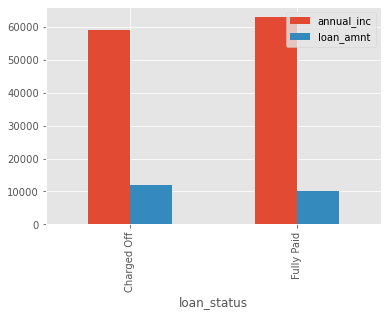

In [55]:
# segmented Analysis - using univariant 

table = pd.pivot_table(data=non_null_df2 ,index=['loan_status'], values=['annual_inc','loan_amnt'],aggfunc={'annual_inc':np.median,'loan_amnt':np.median})
table
table.plot(kind='bar');

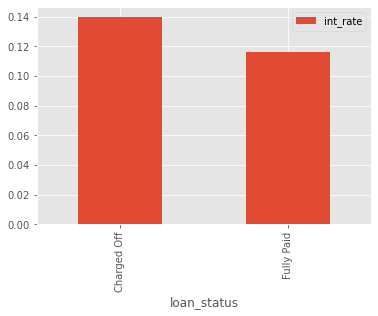

In [56]:
table = pd.pivot_table(data=non_null_df2 ,index=['loan_status'], values=['int_rate'],aggfunc={'int_rate':np.mean})
table
table.plot(kind='bar');

<AxesSubplot:title={'center':'int_rate'}, xlabel='loan_status'>

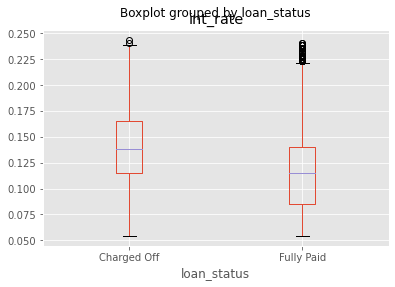

In [57]:
non_null_df2.boxplot(column='int_rate',by='loan_status')

In [58]:
# First separate variables based on categorical and Continous 

numericalValue_list = []
categoricalValue_list = []

for column in non_null_df2:
    if is_numeric_dtype(non_null_df2[column]):
        numericalValue_list.append(column)
    elif is_string_dtype(non_null_df2[column]):
        categoricalValue_list.append(column)    

print("Categorical Columns > ",categoricalValue_list)
print ("\n")
print("Continous Columns > ",numericalValue_list)

Categorical Columns >  ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


Continous Columns >  ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies', 'year', 'month']


In [59]:
# Categorical Columns >  ['grade', 'sub_grade', 'emp_title', 'home_ownership', 'verification_status', 'loan_status', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']

# Continous Columns >  ['id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies', 'year', 'month']

In [60]:
loan_correlation= non_null_df2.corr()
loan_correlation

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,pub_rec_bankruptcies,year,month
id,1.00,0.12,0.13,0.24,0.19,0.06,0.07,0.11,0.02,0.09,-0.01,-0.04,0.01,-0.02,-0.01,0.09,0.03,NaN,NaN,0.11,0.20,0.09,0.12,-0.05,0.04,-0.01,0.14,-0.01,0.85,0.39
loan_amnt,0.12,1.00,0.98,0.93,0.35,0.32,0.93,0.11,0.35,0.07,-0.04,0.01,0.13,-0.06,0.27,0.06,0.20,NaN,NaN,0.87,0.84,0.83,0.72,0.06,0.15,0.08,0.46,-0.04,0.11,0.06
funded_amnt,0.13,0.98,1.00,0.95,0.33,0.33,0.95,0.11,0.34,0.07,-0.04,0.01,0.13,-0.06,0.26,0.06,0.19,NaN,NaN,0.89,0.86,0.85,0.73,0.06,0.15,0.08,0.46,-0.04,0.12,0.04
funded_amnt_inv,0.24,0.93,0.95,1.00,0.35,0.32,0.90,0.12,0.33,0.08,-0.05,-0.01,0.12,-0.06,0.24,0.07,0.18,NaN,NaN,0.87,0.90,0.83,0.72,0.04,0.13,0.07,0.46,-0.04,0.26,0.07
term,0.19,0.35,0.33,0.35,1.00,0.45,0.08,0.10,0.05,0.08,0.00,0.05,0.04,0.01,0.06,0.07,0.08,NaN,NaN,0.31,0.32,0.20,0.51,0.02,0.12,0.04,0.27,0.01,0.25,0.04
int_rate,0.06,0.32,0.33,0.32,0.45,1.00,0.29,0.00,0.06,0.13,0.16,0.13,0.01,0.10,0.09,0.47,-0.05,NaN,NaN,0.31,0.30,0.19,0.54,0.10,0.13,0.07,0.18,0.09,0.04,0.03
installment,0.07,0.93,0.95,0.90,0.08,0.29,1.00,0.08,0.35,0.06,-0.03,0.00,0.13,-0.05,0.27,0.09,0.17,NaN,NaN,0.85,0.81,0.84,0.63,0.07,0.12,0.08,0.40,-0.04,0.05,0.03
emp_length,0.11,0.11,0.11,0.12,0.10,0.00,0.08,1.00,0.12,0.05,0.01,0.01,0.07,0.06,0.13,0.01,0.17,NaN,NaN,0.10,0.11,0.09,0.09,-0.01,0.02,0.01,0.07,0.06,0.11,0.02
annual_inc,0.02,0.35,0.34,0.33,0.05,0.06,0.35,0.12,1.00,-0.14,0.02,0.04,0.20,-0.03,0.39,0.02,0.31,NaN,NaN,0.33,0.32,0.33,0.23,0.02,0.04,0.02,0.19,-0.02,0.02,0.01
dti,0.09,0.07,0.07,0.08,0.08,0.13,0.06,0.05,-0.14,1.00,-0.03,0.00,0.30,-0.01,0.25,0.29,0.24,NaN,NaN,0.07,0.08,0.04,0.12,-0.01,0.03,0.01,0.01,0.01,0.09,0.01


In [61]:
# Bivariat Analysis - Purpose Vs Loan (Group By)

In [62]:
purpose_vs_loan = all_record_After_Cleaning.groupby(['purpose', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()

In [63]:
purpose_vs_loan['Total'] = purpose_vs_loan['Charged Off'] + purpose_vs_loan['Current'] + purpose_vs_loan['Fully Paid'] 
purpose_vs_loan['Chargedoff_Proportion'] = purpose_vs_loan['Charged Off'] / purpose_vs_loan['Total']
purpose_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,purpose,Charged Off,Current,Fully Paid,Total,Chargedoff_Proportion
11,small_business,475.00,74.00,"1,279.00","1,828.00",0.26
10,renewable_energy,19.00,1.00,83.00,103.00,0.18
3,educational,56.00,0.00,269.00,325.00,0.17
9,other,633.00,128.00,"3,232.00","3,993.00",0.16
8,moving,92.00,7.00,484.00,583.00,0.16
5,house,59.00,14.00,308.00,381.00,0.15
7,medical,106.00,12.00,575.00,693.00,0.15
2,debt_consolidation,"2,767.00",586.00,"15,288.00","18,641.00",0.15
12,vacation,53.00,6.00,322.00,381.00,0.14
4,home_improvement,347.00,101.00,"2,528.00","2,976.00",0.12


In [64]:
# Bivariat Analysis - Grade Vs Loan (Group By)

In [65]:
grade_vs_loan = all_record_After_Cleaning.groupby(['grade', 'loan_status']).loan_status.count().unstack().fillna(0).reset_index()

In [66]:
grade_vs_loan['Total'] = grade_vs_loan['Charged Off'] + grade_vs_loan['Current'] + grade_vs_loan['Fully Paid'] 
grade_vs_loan['Chargedoff_Proportion'] = grade_vs_loan['Charged Off'] / grade_vs_loan['Total']
grade_vs_loan.sort_values('Chargedoff_Proportion', ascending=False)

loan_status,grade,Charged Off,Current,Fully Paid,Total,Chargedoff_Proportion
6,G,101,17,198,316,0.32
5,F,319,73,657,1049,0.30
4,E,715,179,1948,2842,0.25
3,D,1118,222,3967,5307,0.21
2,C,1347,264,6487,8098,0.17
1,B,1425,345,10250,12020,0.12
0,A,602,40,9443,10085,0.06
